# Multi-instrument fitting

In this notebook, we will demonstrate `juliet`'s capability of simultaneously fitting multiple instruments with joint transit and eclipse model.

- Data used: WASP-18, TESS Sector 2, 3, 29, 30 and 69 (Data can be found in the 'Data' folder)
- Model: Transit and Eclipse model (same transit depth for each sector, but different eclipse depths for each sector)
- `juliet` version: `dev` version of `juliet` for which the pull request is opened ([this](https://github.com/Jayshil/juliet/tree/dev) version)

First of all, let us import necessary packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import juliet
import os
import matplotlib.gridspec as gd
import astropy.units as u
import multiprocessing
multiprocessing.set_start_method('fork')

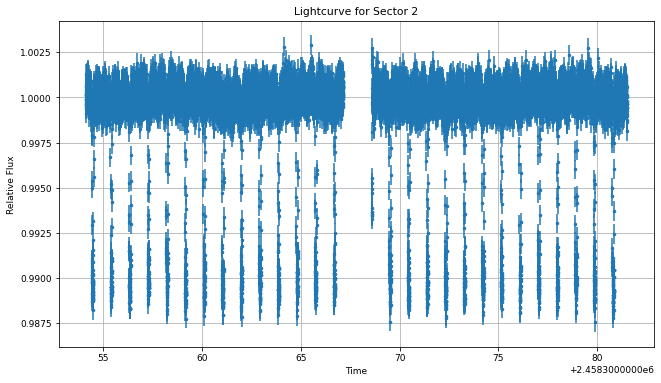

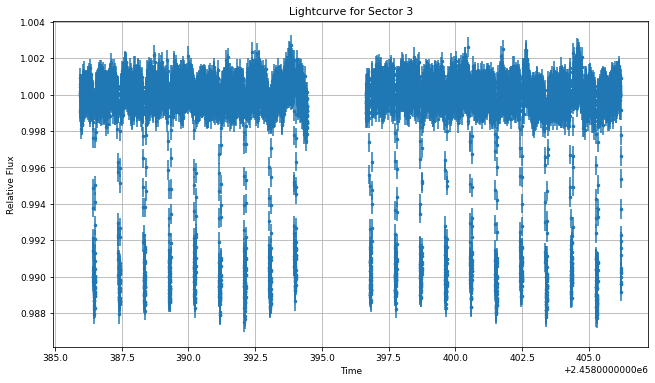

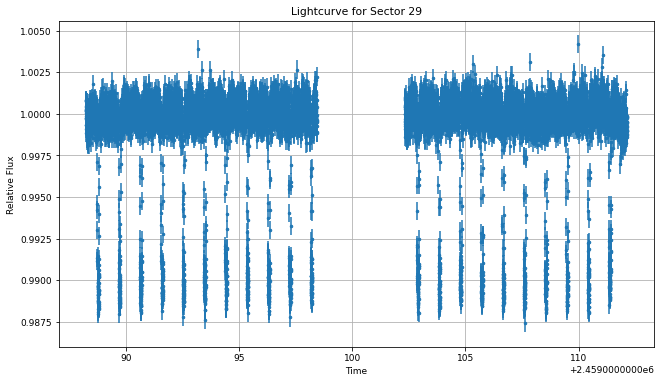

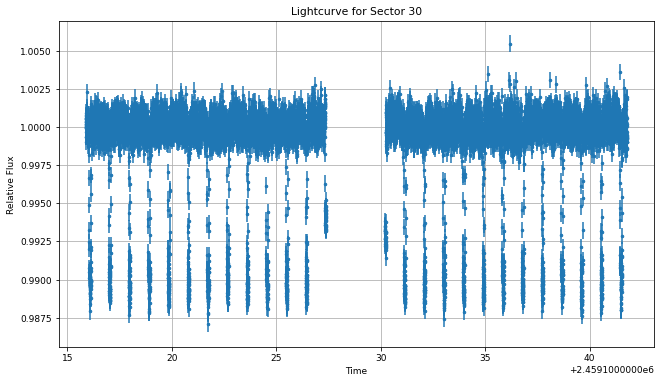

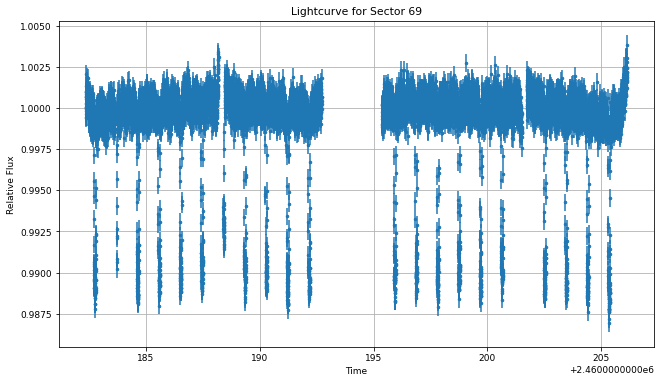

In [2]:
# Loading and storing the data the way juliet understands
instruments = ['TESS2', 'TESS3', 'TESS29', 'TESS30', 'TESS69']
tim, fl, fle = {}, {}, {}
for i in range(len(instruments)):
    tim7, fl7, fle7 = np.loadtxt(os.getcwd() + '/Data/WASP-18_' + instruments[i] + '.dat',\
                                 usecols=(0,1,2), unpack=True)
    tim[instruments[i]], fl[instruments[i]], fle[instruments[i]] = tim7, fl7, fle7

# And visualise the data
for i in tim.keys():
    plt.figure(figsize=(16/1.5, 9/1.5))
    plt.errorbar(tim[i], fl[i], yerr=fle[i], fmt='.')
    plt.xlabel('Time')
    plt.ylabel('Relative Flux')
    plt.title('Lightcurve for Sector ' + i[4:])
    plt.grid()
    plt.show()

The data looks nice! Transits of the planet is clearly visible.

Since, we are interested in fitting transit and eclipse, we would,
- Include priors on eclipse depth, `fp`
- Include LDCs.
- Note that `p` and `fp` both are now planetary _and_ instrumental parameters. And we have two instruments: TESS2 and TESS3. In the present examples, we keep the same planet-to-star radius ratio for both of the instruments. To do so, we will use `p_p1_TESS2_TESS3` in prior list.
- However, we would keep different `fp` for different instruments (this is useful if we want to check the temporal variability of the parameter). For this, we will provide _five_ parameters for eclipse depths, `fp_p1_TESS2`, `fp_p1_TESS3`, `fp_p1_TESS29`, `fp_p1_TESS30` and `fp_p1_TESS69` in prior.
- Note also that while listing priors for `p` and `fp`, the planet number goes _before_ instrument. That means, `p_p1_TESS2` is valid, but `p_TESS2_p1` is not valid.
- In this example, we share `p_p1` for both instruments, but this is not necessary. One can provide different `p_p1` for both instruments.
- Although `fp` is planetary _and_ instrumental parameter, the secondary eclipse time is still _only_ planetary parameter, i.e., we will use `t_secondary_p1`.

In [3]:
# Some planetary parameters (to provide priors)
# All parameters are taken from Cortés-Zuleta et al. 2020
per, per_err = 0.94145223, 0.00000024
bjd0, bjd0_err = 2456740.80560, 0.00019
rho, rho_err = ((0.795 * u.g/u.cm**3).to(u.kg/u.m**3)).value, \
     ((np.sqrt((0.110**2) + (0.089**2)) * u.g/u.cm**3).to(u.kg/u.m**3)).value

## Computing transit and eclipse time for the epoch from the data
cycle = round((tim[instruments[-1]][-1] - bjd0)/per)
tc1 = np.random.normal(bjd0, bjd0_err, 100000) + cycle*np.random.normal(per, per_err, 100000)
tc2 = tc1 + (np.random.normal(per, per_err, 100000)/2)

tc0, tc0_err = np.median(tc1), np.std(tc1)
tc02, tc02_err = np.median(tc2), np.std(tc2)

# And priros (Note that p and fp are planetary and instrumental parameters):
par_P = ['P_p1', 't0_p1', 'p_p1_' + '_'.join(instruments), 'b_p1',\
         'q1_' + '_'.join(instruments), 'q2_' + '_'.join(instruments), 'rho',\
         'fp_p1_TESS2', 'fp_p1_TESS3', 'fp_p1_TESS29', 'fp_p1_TESS30', 'fp_p1_TESS69',\
         't_secondary_p1', 'ecc_p1', 'omega_p1']
dist_P = ['normal', 'normal', 'uniform', 'uniform',\
          'uniform', 'uniform', 'normal',\
          'uniform', 'uniform', 'uniform', 'uniform', 'uniform',\
          'normal', 'fixed', 'fixed']
hyper_P = [[per, per_err], [tc0, tc0_err], [0., 1.], [0., 1.],\
           [0.,1.], [0.,1.], [rho, rho_err],\
           [0.e-6, 500.e-6], [0.e-6, 500.e-6], [0.e-6, 500.e-6], [0.e-6, 500.e-6], [0.e-6, 500.e-6],\
           [tc02, tc02_err], 0., 90.]

## Instrumental and GP parameters
par_ins, dist_ins, hyper_ins = [], [], []
for i in range(len(instruments)):
    par_ins = par_ins + ['mdilution_' + instruments[i], 'mflux_' + instruments[i], \
                         'sigma_w_' + instruments[i]]
    dist_ins = dist_ins + ['fixed', 'normal', 'loguniform']
    hyper_ins = hyper_ins + [1., [0., 0.1], [0.1, 10000.]]

par_gp, dist_gp, hyper_gp = [], [], []
for i in range(len(instruments)):
    par_gp = par_gp + ['GP_sigma_' + instruments[i], 'GP_timescale_' + instruments[i],\
                       'GP_rho_' + instruments[i]]
    dist_gp = dist_gp + ['loguniform', 'loguniform', 'loguniform']
    hyper_gp = hyper_gp + [[1e-5, 10000.], [1e-3, 1e2], [1e-3, 1e2]]

par_tot = par_P + par_ins + par_gp
dist_tot = dist_P + dist_ins + dist_gp
hyper_tot = hyper_P + hyper_ins + hyper_gp

priors_tot = juliet.utils.generate_priors(par_tot, dist_tot, hyper_tot)

In [4]:
# And fitting it!
dataset = juliet.load(priors=priors_tot, t_lc=tim, y_lc=fl, yerr_lc=fle,\
    GP_regressors_lc=tim, out_folder=os.getcwd() + '/Analysis/Multi-Transit-Eclipse_3')
res = dataset.fit(sampler = 'dynesty', nthreads=8)

59024it [11:26:07,  1.43it/s, +500 | bound: 772 | nc: 1 | ncall: 3362042 | eff(%):  1.771 | loglstar:   -inf < 464891.785 <    inf | logz: 464774.347 +/-  0.490 | dlogz:  0.001 >  0.509]


In [5]:
os.system("cat Analysis/Multi-Transit-Eclipse_3/posteriors.dat")

# Parameter Name     	 	 Median       	 	 Upper 68 CI  	 	 Lower 68 CI 
P_p1               	 	 0.9414524071 	 	 0.0000000228 	 	 0.0000000224
a_p1               	 	 3.4652244476 	 	 0.0138355939 	 	 0.0140520721
t0_p1              	 	 2460206.2947874456 	 	 0.0000349856 	 	 0.0000327285
p_p1_TESS2_TESS3_TESS29_TESS30_TESS69 	 	 0.0979195223 	 	 0.0002063071 	 	 0.0001989196
b_p1               	 	 0.3789563205 	 	 0.0109757227 	 	 0.0111656538
q1_TESS2_TESS3_TESS29_TESS30_TESS69 	 	 0.2263710878 	 	 0.0163097913 	 	 0.0159236067
q2_TESS2_TESS3_TESS29_TESS30_TESS69 	 	 0.2910146162 	 	 0.0316240621 	 	 0.0281277430
rho                	 	 888.0749193511 	 	 10.6799974470 	 	 10.7600895125
fp_p1_TESS2        	 	 0.0003650518 	 	 0.0000242893 	 	 0.0000253626
fp_p1_TESS3        	 	 0.0003459646 	 	 0.0000282077 	 	 0.0000296168
fp_p1_TESS29       	 	 0.0004112125 	 	 0.0000241396 	 	 0.0000250191
fp_p1_TESS30       	 	 0.0004323062 	 	 0.0000314920 	 	 0.0000319745
fp_p1_TESS69       	 	 0.

0

0003284458 	 	 0.0000308921 	 	 0.0000322990
t_secondary_p1     	 	 2460206.7646723562 	 	 0.0003054477 	 	 0.0002837055
mflux_TESS2        	 	 0.0011565019 	 	 0.0029330193 	 	 0.0028249510
sigma_w_TESS2      	 	 1.4718063700 	 	 6.9615050720 	 	 1.2012569007
mflux_TESS3        	 	 -0.0029641066 	 	 0.0032469120 	 	 0.0035138888
sigma_w_TESS3      	 	 2.2017676833 	 	 11.2490946965 	 	 1.9089099868
mflux_TESS29       	 	 -0.0056908738 	 	 0.0032736540 	 	 0.0037709614
sigma_w_TESS29     	 	 204.8463404629 	 	 9.4629383727 	 	 9.2088735385
mflux_TESS30       	 	 0.0030478835 	 	 0.0038139978 	 	 0.0031171159
sigma_w_TESS30     	 	 177.1595316614 	 	 9.4777028197 	 	 10.1612288690
mflux_TESS69       	 	 0.0061597836 	 	 0.0050825664 	 	 0.0040282981
sigma_w_TESS69     	 	 3.1539756969 	 	 24.1558732117 	 	 2.8055093478
GP_sigma_TESS2     	 	 0.0000221951 	 	 0.0000305636 	 	 0.0000095581
GP_timescale_TESS2 	 	 0.0138650555 	 	 0.0108184681 	 	 0.0079697252
GP_rho_TESS2       	 	 53.7902

The posteriors look good for most of the planetary parameters and seems to agree with their corresponding values from the literature.

Let's now visualise our results to make sure that everything was smooth.

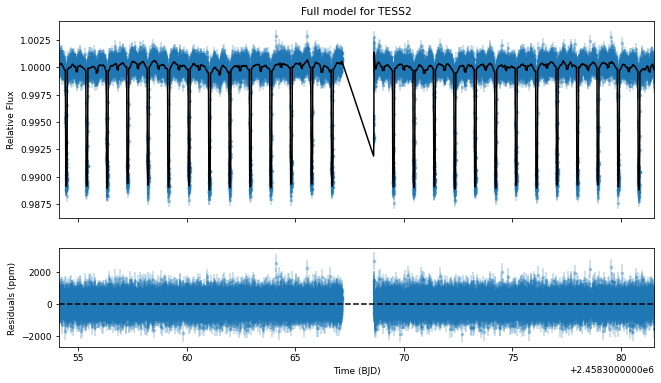

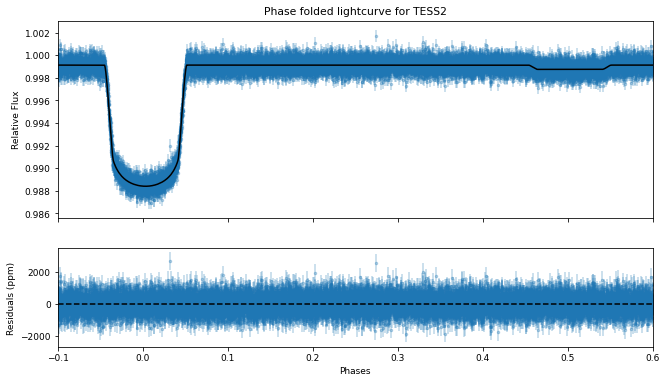

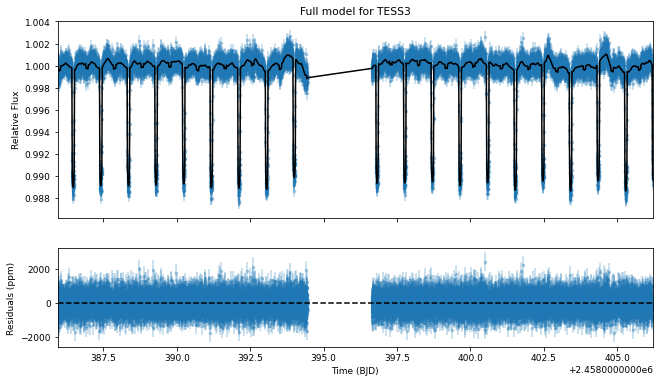

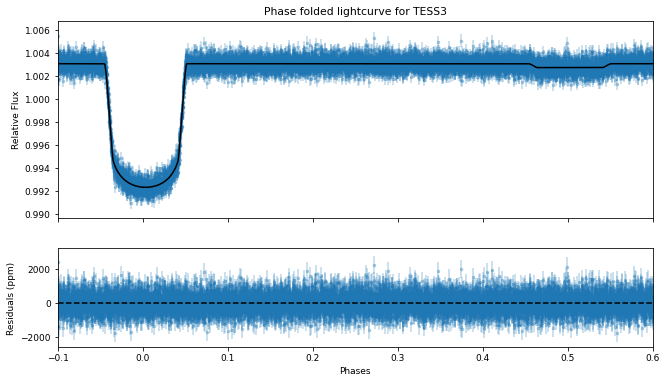

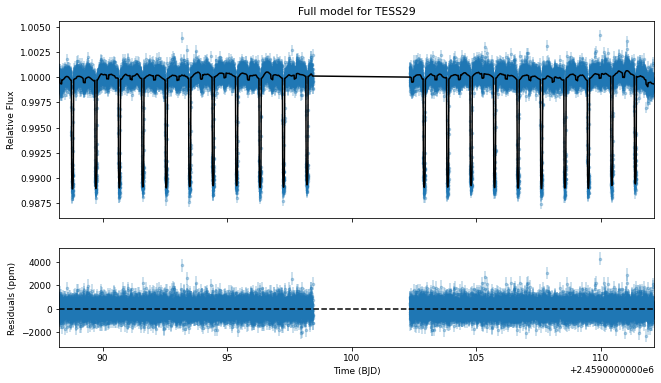

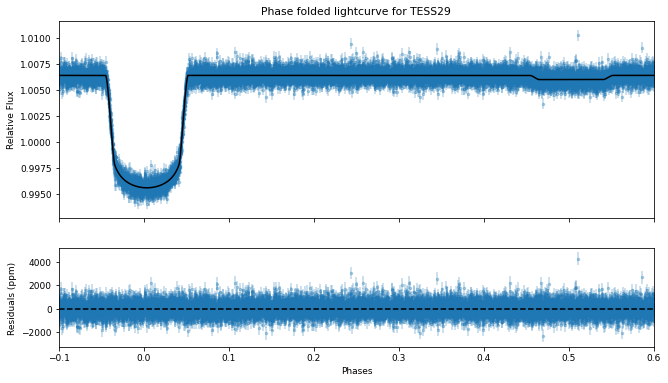

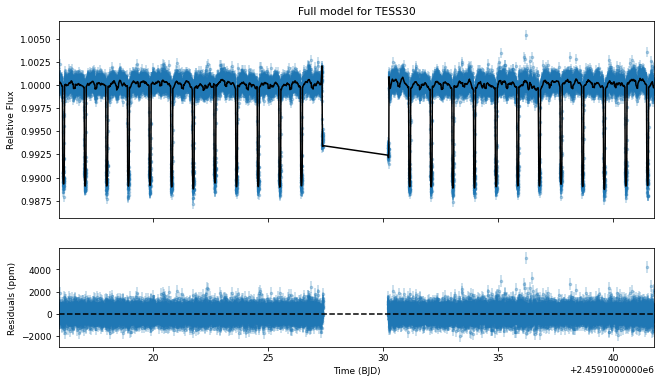

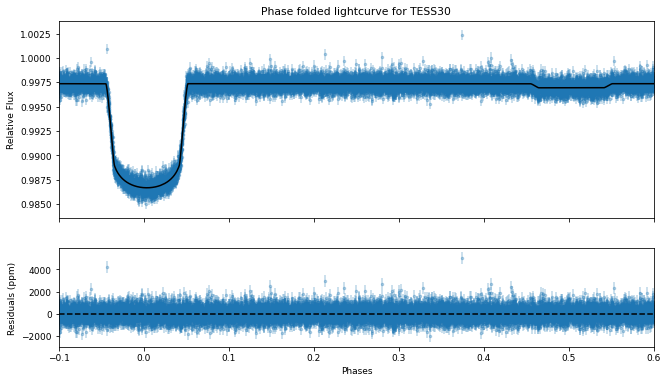

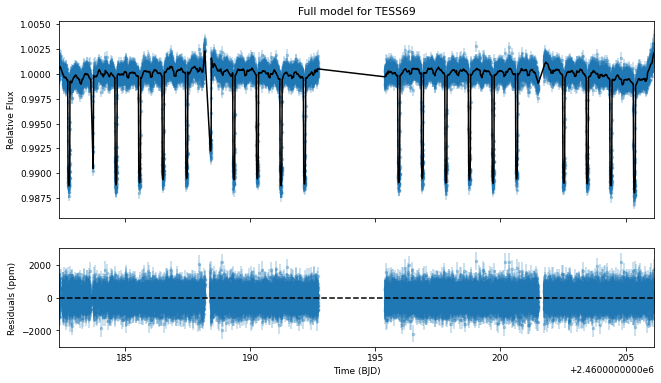

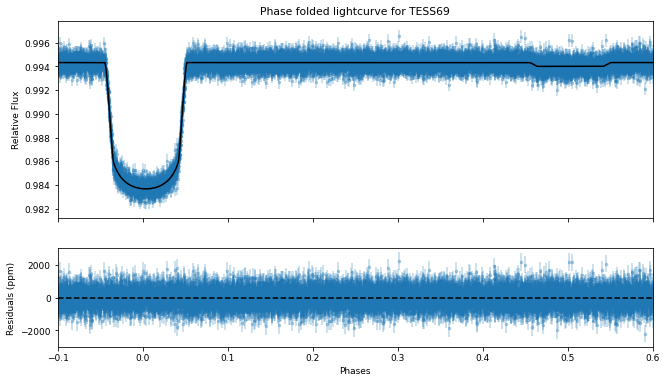

In [6]:
for i in tim.keys():
    # juliet best fit model
    model = res.lc.evaluate(i)
    gp_model = res.lc.model[i]['GP']
    transit_model = res.lc.model[i]['deterministic']
    # Making a plot
    fig = plt.figure(figsize=(16/1.5,9/1.5))
    gs = gd.GridSpec(2,1, height_ratios=[2,1])

    # Top panel
    ax1 = plt.subplot(gs[0])
    ax1.errorbar(tim[i], fl[i], yerr=fle[i], fmt='.', alpha=0.3)
    ax1.plot(tim[i], model, c='k', zorder=100)
    ax1.set_ylabel('Relative Flux')
    ax1.set_xlim(np.min(tim[i]), np.max(tim[i]))
    ax1.xaxis.set_major_formatter(plt.NullFormatter())

    # Bottom panel
    ax2 = plt.subplot(gs[1])
    ax2.errorbar(tim[i], (fl[i]-model)*1e6, yerr=fle[i]*1e6, fmt='.', alpha=0.3)
    ax2.axhline(y=0.0, c='black', ls='--', zorder=100)
    ax2.set_ylabel('Residuals (ppm)')
    ax2.set_xlabel('Time (BJD)')
    ax2.set_xlim(np.min(tim[i]), np.max(tim[i]))

    ax1.set_title('Full model for ' + i)
    plt.show()

    # Phase folded lightcurves:
    phs = juliet.utils.get_phases(tim[i], per, bjd0, phmin=0.8)
    idx = np.argsort(phs)
    # Making a plot
    fig = plt.figure(figsize=(16/1.5,9/1.5))
    gs = gd.GridSpec(2,1, height_ratios=[2,1])

    # Top panel
    ax1 = plt.subplot(gs[0])
    ax1.errorbar(phs, fl[i]-gp_model, yerr=fle[i], fmt='.', alpha=0.3)
    ax1.plot(phs[idx], transit_model[idx], c='k', zorder=100)
    ax1.set_ylabel('Relative Flux')
    ax1.set_xlim(-0.1, 0.6)
    #ax1.set_ylim(0.998, 1.002)
    ax1.xaxis.set_major_formatter(plt.NullFormatter())

    # Bottom panel
    ax2 = plt.subplot(gs[1])
    ax2.errorbar(phs, (fl[i]-model)*1e6, yerr=fle[i]*1e6, fmt='.', alpha=0.3)
    ax2.axhline(y=0.0, c='black', ls='--', zorder=100)
    ax2.set_ylabel('Residuals (ppm)')
    ax2.set_xlabel('Phases')
    ax2.set_xlim(-0.1, 0.6)

    ax1.set_title('Phase folded lightcurve for ' + i)
    plt.show()

This is fantastic!